<a href="https://colab.research.google.com/github/dimasfajrip/capstone_project_ibmXhacktiv8/blob/main/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capstone Project IBM x Hacktiv8

## Scraping Data

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
import re

# Setup Chrome
options = Options()
options.add_argument("--start-maximized")
driver = webdriver.Chrome(service=Service(), options=options)

# Inisialisasi penyimpanan data
all_features = set()  # Menyimpan semua fitur unik
data_rows = []        # Menyimpan data tiap rumah sebagai dictionary

def scrape_detail():
    global all_features, data_rows
    try:
        wait = WebDriverWait(driver, 10)
        title = wait.until(EC.presence_of_element_located(
            (By.CSS_SELECTOR, "h1[class*='p-eciW3Ko_']"))).text

        if "Dijual Rumah" not in title:
            print("Lewati: Judul bukan 'Dijual Rumah'")
            return

        price = wait.until(EC.presence_of_element_located(
            (By.CSS_SELECTOR, "div.summary__price-and-fomo"))).text
        address = wait.until(EC.presence_of_element_located(
            (By.CSS_SELECTOR, "p[class*='p-hnE2cqE_']"))).text
        # Tambahan di dalam fungsi scrape_detail()
        harga_per_m2 = "-"
        try:
            harga_per_m2_elements = driver.find_elements(By.CSS_SELECTOR, "div.p-eciW3Ko_.p-hnE2cqE_")
            for el in harga_per_m2_elements:
                text = el.text.strip()
                if "jt/m²" in text.lower():
                    harga_per_m2 = text
                    break
        except:
            harga_per_m2 = "-"

        specs = wait.until(EC.presence_of_all_elements_located(
            (By.CSS_SELECTOR, "span[class*='p-hnE2cqE_']")))

        room = land_area = building_area = house_document = "-"

        for spec in specs:
            text = spec.text.lower()
            if "kamar tidur" in text:
                room = spec.text.strip()
            elif "luas tanah" in text:
                land_area = spec.text.strip()
            elif "luas bangunan" in text:
                building_area = spec.text.strip()
            elif ("sertifikat hak milik" in text or
                "hak guna bangunan" in text or
                "girik" in text or
                "shm" in text or
                "hgb" in text):
                house_document = spec.text.strip()

        # Fasilitas dari source code kedua
        fasilitas_elements = driver.find_elements(By.CSS_SELECTOR, "div.p-eciW3Ko_.p-7KvUfE4_")
        fasilitas_texts = [el.text.strip().lower() for el in fasilitas_elements]

        fasilitas = {
            'carport': 0, 'garasi': 0, 'kamar mandi': 0, 'lantai': 0, 'akses mobil': 0,
            'listrik': 0, 'sumber air': 'PDAM', 'perabot': 'Tidak', 'keamanan 24 jam': 0,
            'kolam renang': 0, 'ac': 0, 'akses 24/7': 0, 'akses wifi': 0, 'atm center': 0,
            'balkon': 0, 'bank': 0, 'bathtub': 0, 'cctv': 0, 'gorden': 0, 'gym': 0,
            'internet berkecepatan': 0, 'kasur': 0, 'kitchen set': 0, 'kolam publik': 0,
            'kompor': 0, 'kulkas': 0, 'lemari pakaian': 0, 'microwave': 0, 'minimarket': 0,
            'musholla': 0, 'oven': 0, 'pompa air': 0, 'restoran': 0, 'shower': 0,
            'taman': 0, 'tangki air': 0, 'telepon': 0, 'tempat parkir': 0,
            'water heater': 0, 'jogging track': 0
        }


        boolean_map = {
            'keamanan': 'keamanan 24 jam',
            'kolam renang': 'kolam renang',
            'ac': 'ac',
            'akses 24/7': 'akses 24/7',
            'akses wifi': 'akses wifi',
            'atm center': 'atm center',
            'balkon': 'balkon',
            'bank': 'bank',
            'bathtub': 'bathtub',
            'cctv': 'cctv',
            'gorden': 'gorden',
            'gym': 'gym',
            'internet': 'internet berkecepatan',
            'kasur': 'kasur',
            'kitchen set': 'kitchen set',
            'kolam publik': 'kolam publik',
            'kompor': 'kompor',
            'kulkas': 'kulkas',
            'lemari pakaian': 'lemari pakaian',
            'microwave': 'microwave',
            'minimarket': 'minimarket',
            'musholla': 'musholla',
            'oven': 'oven',
            'pompa air': 'pompa air',
            'restoran': 'restoran',
            'shower': 'shower',
            'taman': 'taman',
            'tangki air': 'tangki air',
            'telepon': 'telepon',
            'tempat parkir': 'tempat parkir',
            'water heater': 'water heater',
            'jogging track': 'jogging track'
        }

        for item in fasilitas_texts:
            item_lower = item.lower()

            # Fasilitas boolean
            for key, field in boolean_map.items():
                if key in item_lower:
                    fasilitas[field] = 1

            # Fasilitas numerik atau khusus
            if 'carport' in item_lower:
                match = re.search(r'\d+', item_lower)
                if match:
                    fasilitas['carport'] = int(match.group())
            elif 'garasi' in item_lower:
                match = re.search(r'\d+', item_lower)
                if match:
                    fasilitas['garasi'] = int(match.group())
            elif 'kamar mandi' in item_lower:
                match = re.search(r'\d+', item_lower)
                if match:
                    fasilitas['kamar mandi'] = int(match.group())
            elif 'lantai' in item_lower:
                match = re.search(r'\d+', item_lower)
                if match:
                    fasilitas['lantai'] = int(match.group())
            elif 'akses mobil' in item_lower:
                match = re.search(r'\d+', item_lower)
                if match:
                    fasilitas['akses mobil'] = int(match.group())
            elif 'listrik' in item_lower:
                match = re.search(r'\d+', item_lower.replace('.', ''))
                if match:
                    fasilitas['listrik'] = int(match.group())
            elif 'sumber air' in item_lower:
                if 'pdam' in item_lower:
                    fasilitas['sumber air'] = 'PDAM'
                elif 'pam' in item_lower:
                    fasilitas['sumber air'] = 'PAM'
                else:
                    fasilitas['sumber air'] = item
            elif 'perabot' in item_lower:
                fasilitas['perabot'] = 'Perabot'

        rumah_info = {
            "Judul": title,
            "Harga": price,
            "Harga per m²": harga_per_m2,
            "Alamat": address,
            "Kamar": room,
            "Luas Tanah": land_area,
            "Luas Bangunan": building_area,
            "Kepemilikan Tanah": house_document
        }
        # Tambahan 2 kolom ekonomi makro
        rumah_info["Pertumbuhan IHPR YoY"] = "1.05%"
        rumah_info["Suku Bunga KPR Nasional"] = "10.38%"

        # Gabungkan info fasilitas ke rumah_info
        for key, value in fasilitas.items():
            rumah_info[key.capitalize()] = value
            all_features.add(key.capitalize())

        data_rows.append(rumah_info)
        print("✔ Data ditambahkan:", title)

    except Exception as e:
        print("Gagal ambil data:", e)

# Iterasi halaman
for page_num in range(1, 100):
    try:
        url = f"https://www.pinhome.id/dijual/cari/kota-surabaya-209?buildingType=building_type.house&page={page_num}"
        driver.get(url)
        time.sleep(3)

        # Tutup popup jika muncul
        try:
            WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.CLASS_NAME, 'pin-popup__dialog___u1yak'))
            )
            close_btn = driver.find_element(By.CLASS_NAME, 'pin-popup__close-btn___1z0op')
            close_btn.click()
            time.sleep(1)
            print("Popup ditutup")
        except Exception:
            print("Popup tidak muncul")

        wait = WebDriverWait(driver, 10)
        cards = wait.until(EC.presence_of_all_elements_located(
            (By.CSS_SELECTOR, 'a.pin-card__link___h5vvm')
        ))

        base_url = "https://www.pinhome.id"
        links = []
        for card in cards:
            href = card.get_attribute('href')
            if href:
                links.append(href if href.startswith('http') else base_url + href)

        for link in links:
            try:
                driver.execute_script("window.open('');")
                driver.switch_to.window(driver.window_handles[1])
                driver.get(link)
                time.sleep(2)
                scrape_detail()
                driver.close()
                driver.switch_to.window(driver.window_handles[0])
                time.sleep(1)
            except Exception as detail_error:
                print(f"Gagal buka detail rumah: {detail_error}")
                driver.switch_to.window(driver.window_handles[0])

    except Exception as page_error:
        print(f"Gagal buka halaman {page_num}: {page_error}")

# Selesai scraping
driver.quit()

# Ubah data ke DataFrame
columns = ["Judul", "Harga", "Harga per m²", "Alamat", "Kamar", "Luas Tanah", "Luas Bangunan", "Kepemilikan Tanah",
           "Pertumbuhan IHPR YoY", "Suku Bunga KPR Nasional"] + sorted(all_features)

df = pd.DataFrame(data_rows)

# Pastikan semua kolom tersedia, isi dengan NaN jika tidak ada
for col in columns:
    if col not in df.columns:
        df[col] = "NaN"

# Urutkan kolom
df = df[columns]

# Simpan ke CSV
df.to_csv("dataset_baru.csv", index=False, encoding="utf-8")
print("✔ Data CSV dengan fasilitas berhasil disimpan.")


## Exploratory Data Analysis

In [8]:
#import library
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import re

#Read Data
url = 'https://raw.githubusercontent.com/dimasfajrip/capstone_project_ibmXhacktiv8/main/dataset_baru.csv'
df = pd.read_csv(url)

### Preliminary EDA

In [9]:
#Show Data
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3435 entries, 0 to 3434
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Judul                    3435 non-null   object
 1   Harga                    3435 non-null   object
 2   Harga per m²             3435 non-null   object
 3   Alamat                   3435 non-null   object
 4   Kamar                    3435 non-null   object
 5   Luas Tanah               3435 non-null   object
 6   Luas Bangunan            3435 non-null   object
 7   Kepemilikan Tanah        3435 non-null   object
 8   Pertumbuhan IHPR YoY     3435 non-null   object
 9   Suku Bunga KPR Nasional  3435 non-null   object
 10  Ac                       3435 non-null   int64 
 11  Akses 24/7               3435 non-null   int64 
 12  Akses mobil              3435 non-null   int64 
 13  Akses wifi               3435 non-null   int64 
 14  Atm center               3435 non-null  

,Judul,Harga,Harga per m²,Alamat,Kamar,Luas Tanah,Luas Bangunan,Kepemilikan Tanah,Pertumbuhan IHPR YoY,Suku Bunga KPR Nasional,...,Perabot,Pompa air,Restoran,Shower,Sumber air,Taman,Tangki air,Telepon,Tempat parkir,Water heater
0,Dijual Rumah Shm di Jalan Cumpat Nambangan GG....,Rp430 Jt,"Rp8,3 Jt/m²","Kel. Kedung Cowek, Kec. Bulak, Kota Surabaya",3 Kamar Tidur,Luas Tanah 52m²,Luas Bangunan 50m²,Sertifikat Hak Milik,1.05%,10.38%,...,Perabot,0,0,0,PDAM,0,0,0,0,0
1,Dijual Rumah Murah Cepat Surabaya di Dukuh Men...,Rp700 Jt,"Rp8,2 Jt/m²","Kel. Dukuh Menanggal, Kec. Gayungan, Kota Sura...",3 Kamar Tidur,Luas Tanah 85m²,Luas Bangunan 85m²,-,1.05%,10.38%,...,Perabot,0,0,0,PAM,0,0,0,0,0
2,Dijual Rumah 1KT 48m² di Jl Simo Gunung Baru J...,Rp250 Jt,"Rp5,2 Jt/m²","Kel. Putat Jaya, Kec. Sawahan, Kota Surabaya",1 Kamar Tidur,Luas Tanah 48m²,Luas Bangunan 48m²,Sertifikat Hak Milik,1.05%,10.38%,...,Perabot,0,0,0,PDAM,0,0,0,0,0
3,Dijual Rumah 7KT 116m² di Jl Krakatau Raya No ...,"Rp1,4 M","Rp12,7 Jt/m²","Kel. Petemon, Kec. Sawahan, Kota Surabaya",7 Kamar Tidur,Luas Tanah 116m²,Luas Bangunan 195m²,Sertifikat Hak Milik,1.05%,10.38%,...,Perabot,0,0,0,PDAM,0,0,0,0,0
4,Dijual Rumah SHM Lokasi Strategis (Bisa Nego) ...,"Rp2,2 M","Rp22,9 Jt/m²","Kel. Gading, Kec. Tambaksari, Kota Surabaya",4 Kamar Tidur,Luas Tanah 96m²,Luas Bangunan 96m²,Sertifikat Hak Milik,1.05%,10.38%,...,Perabot,0,0,0,PDAM,0,0,0,0,0
5,Dijual Rumah Asri 1 Lantai Taman Luas Depan Ma...,Rp6 M,Rp15 Jt/m²,"Kel. Rungkut Kidul, Kec. Rungkut, Kota Surabaya",5 Kamar Tidur,Luas Tanah 400m²,Luas Bangunan 250m²,Sertifikat Hak Milik,1.05%,10.38%,...,Perabot,0,0,0,PDAM,0,0,0,0,0
6,Dijual Rumah 2 Lantai Nyaman Strategis di Teng...,"Rp3,3 M","Rp16,5 Jt/m²","Kel. Tengilis Mejoyo, Kec. Tenggilis Mejoyo, K...",5 Kamar Tidur,Luas Tanah 200m²,Luas Bangunan 300m²,Sertifikat Hak Milik,1.05%,10.38%,...,Perabot,1,0,0,PDAM,0,1,0,0,0
7,Dijual Rumah Lokasi Strategis Surabaya di Teng...,"Rp3,3 M","Rp16,5 Jt/m²","Kel. Tengilis Mejoyo, Kec. Tenggilis Mejoyo, K...",5 Kamar Tidur,Luas Tanah 200m²,Luas Bangunan 300m²,Sertifikat Hak Milik,1.05%,10.38%,...,Perabot,0,0,0,sumber air air tanah,0,0,0,0,1
8,Dijual Rumah Tenggilis Surabaya di Jjj,"Rp3,3 M","Rp16,5 Jt/m²","Kel. Tengilis Mejoyo, Kec. Tenggilis Mejoyo, K...",5 Kamar Tidur,Luas Tanah 200m²,Luas Bangunan 300m²,Sertifikat Hak Milik,1.05%,10.38%,...,Perabot,0,0,0,PDAM,0,0,0,0,0
9,Dijual Rumah Cepat Butuh Uang di di Jual Cepat...,"Rp2,2 M",Rp9 Jt/m²,"Kel. Penjaringansari (Penjaringan Sari), Kec. ...",4 Kamar Tidur,Luas Tanah 245m²,Luas Bangunan 300m²,Sertifikat Hak Milik,1.05%,10.38%,...,Perabot,0,0,1,PAM,0,0,0,0,1


In [10]:
#clean data
def clean_price(price):
    if pd.isna(price):
        return None

    # Hapus "Rp", " /m²", spasi ekstra, dan ubah ke huruf kecil
    price = price.lower().replace('rp', '').replace('/m²', '').strip()

    # Ganti koma dengan titik agar bisa dikonversi ke float
    price = price.replace(',', '.')

    # Ekstrak angka dan satuan (jt atau miliar)
    match = re.search(r'([\d.]+)\s*(jt|juta|m|miliar)', price)
    if match:
        number = float(match.group(1))
        unit = match.group(2)

        if unit in ['jt', 'juta']:
            return int(number * 1_000_000)
        elif unit in ['m', 'miliar']:
            return int(number * 1_000_000_000)

    return None

def clean_area(area):
    if pd.isna(area):
        return None

    # Hapus kata 'Luas Tanah' atau 'Luas Bangunan' jika ada, serta 'm²'
    area = area.lower().replace("luas tanah", "").replace("luas bangunan", "")
    area = area.replace("m²", "").replace(":", "").strip()

    try:
        return float(area)
    except:
        return None

def clean_room(room):
    if pd.isna(room):
        return None

    #Hapus kata 'Kamar Tidur'
    room = room.lower().replace('kamar tidur', '').strip()

    try:
        return float(room)
    except:
        return None

df['harga_bersih'] = df['Harga'].apply(clean_price)
df['harga_per_m2_bersih'] = df['Harga per m²'].apply(clean_price)
df['Luas_Tanah_Bersih'] = df['Luas Tanah'].apply(clean_area)
df['Luas_Bangunan_Bersih'] = df['Luas Bangunan'].apply(clean_area)
df['Kamar'] = df['Kamar'].apply(clean_room)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3435 entries, 0 to 3434
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Judul                    3435 non-null   object 
 1   Harga                    3435 non-null   object 
 2   Harga per m²             3435 non-null   object 
 3   Alamat                   3435 non-null   object 
 4   Kamar                    3435 non-null   float64
 5   Luas Tanah               3435 non-null   object 
 6   Luas Bangunan            3435 non-null   object 
 7   Kepemilikan Tanah        3435 non-null   object 
 8   Pertumbuhan IHPR YoY     3435 non-null   object 
 9   Suku Bunga KPR Nasional  3435 non-null   object 
 10  Ac                       3435 non-null   int64  
 11  Akses 24/7               3435 non-null   int64  
 12  Akses mobil              3435 non-null   int64  
 13  Akses wifi               3435 non-null   int64  
 14  Atm center              

In [11]:
#delete data
df['Harga'] = df['harga_bersih']
df['Harga per m²'] = df['harga_per_m2_bersih']
df.drop('harga_bersih', axis=1, inplace=True)
df.drop('harga_per_m2_bersih', axis=1, inplace=True)

df['Luas Bangunan'] = df['Luas_Bangunan_Bersih']
df['Luas Tanah'] = df['Luas_Tanah_Bersih']
df.drop('Luas_Bangunan_Bersih', axis=1, inplace=True)
df.drop('Luas_Tanah_Bersih', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3435 entries, 0 to 3434
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Judul                    3435 non-null   object 
 1   Harga                    3434 non-null   float64
 2   Harga per m²             3418 non-null   float64
 3   Alamat                   3435 non-null   object 
 4   Kamar                    3435 non-null   float64
 5   Luas Tanah               3435 non-null   float64
 6   Luas Bangunan            3435 non-null   float64
 7   Kepemilikan Tanah        3435 non-null   object 
 8   Pertumbuhan IHPR YoY     3435 non-null   object 
 9   Suku Bunga KPR Nasional  3435 non-null   object 
 10  Ac                       3435 non-null   int64  
 11  Akses 24/7               3435 non-null   int64  
 12  Akses mobil              3435 non-null   int64  
 13  Akses wifi               3435 non-null   int64  
 14  Atm center              

In [12]:
#split data
# Split alamat berdasarkan koma, hasilnya bisa punya jumlah bagian bervariasi
split_alamat = df['Alamat'].str.split(r",", expand=True)

# Isi kolom sesuai urutan jika tersedia, sisanya akan otomatis jadi NaN jika tidak ada
df['Desa'] = split_alamat[0]
df['Kecamatan'] = split_alamat[1]
df['Kota'] = split_alamat[2]

# Hapus kolom Alamat jika sudah tidak dibutuhkan
df = df.drop(['Alamat'], axis=1)

# Tampilkan hasil
df.head()


,Judul,Harga,Harga per m²,Kamar,Luas Tanah,Luas Bangunan,Kepemilikan Tanah,Pertumbuhan IHPR YoY,Suku Bunga KPR Nasional,Ac,...,Shower,Sumber air,Taman,Tangki air,Telepon,Tempat parkir,Water heater,Desa,Kecamatan,Kota
0,Dijual Rumah Shm di Jalan Cumpat Nambangan GG....,4.300000e+08,8300000.0,3.0,52.0,50.0,Sertifikat Hak Milik,1.05%,10.38%,0,...,0,PDAM,0,0,0,0,0,Kel. Kedung Cowek,Kec. Bulak,Kota Surabaya
1,Dijual Rumah Murah Cepat Surabaya di Dukuh Men...,7.000000e+08,8199999.0,3.0,85.0,85.0,-,1.05%,10.38%,0,...,0,PAM,0,0,0,0,0,Kel. Dukuh Menanggal,Kec. Gayungan,Kota Surabaya
2,Dijual Rumah 1KT 48m² di Jl Simo Gunung Baru J...,2.500000e+08,5200000.0,1.0,48.0,48.0,Sertifikat Hak Milik,1.05%,10.38%,0,...,0,PDAM,0,0,0,0,0,Kel. Putat Jaya,Kec. Sawahan,Kota Surabaya
3,Dijual Rumah 7KT 116m² di Jl Krakatau Raya No ...,1.400000e+09,12700000.0,7.0,116.0,195.0,Sertifikat Hak Milik,1.05%,10.38%,0,...,0,PDAM,0,0,0,0,0,Kel. Petemon,Kec. Sawahan,Kota Surabaya
4,Dijual Rumah SHM Lokasi Strategis (Bisa Nego) ...,2.200000e+09,22900000.0,4.0,96.0,96.0,Sertifikat Hak Milik,1.05%,10.38%,0,...,0,PDAM,0,0,0,0,0,Kel. Gading,Kec. Tambaksari,Kota Surabaya


In [13]:
#convert data
df['Luas Bangunan'] = df['Luas Bangunan'].astype(int)
df['Luas Tanah'] = df['Luas Tanah'].astype(int)
df['Kamar'] = df['Kamar'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3435 entries, 0 to 3434
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Judul                    3435 non-null   object 
 1   Harga                    3434 non-null   float64
 2   Harga per m²             3418 non-null   float64
 3   Kamar                    3435 non-null   int64  
 4   Luas Tanah               3435 non-null   int64  
 5   Luas Bangunan            3435 non-null   int64  
 6   Kepemilikan Tanah        3435 non-null   object 
 7   Pertumbuhan IHPR YoY     3435 non-null   object 
 8   Suku Bunga KPR Nasional  3435 non-null   object 
 9   Ac                       3435 non-null   int64  
 10  Akses 24/7               3435 non-null   int64  
 11  Akses mobil              3435 non-null   int64  
 12  Akses wifi               3435 non-null   int64  
 13  Atm center               3435 non-null   int64  
 14  Balkon                  

In [14]:
df.describe()

,Harga,Harga per m²,Kamar,Luas Tanah,Luas Bangunan,Ac,Akses 24/7,Akses mobil,Akses wifi,Atm center,...,Musholla,Oven,Pompa air,Restoran,Shower,Taman,Tangki air,Telepon,Tempat parkir,Water heater
count,3.434000e+03,3.418000e+03,3435.000000,3435.000000,3435.000000,3435.000000,3435.000000,3435.000000,3435.000000,3435.000000,...,3435.000000,3435.000000,3435.000000,3435.000000,3435.000000,3435.000000,3435.000000,3435.000000,3435.000000,3435.000000
mean,3.341992e+09,1.598581e+07,3.940320,194.756332,218.448035,0.135953,0.143814,1.045706,0.015429,0.150801,...,0.010189,0.009607,0.159534,0.014265,0.280932,0.020961,0.129840,0.043668,0.036972,0.095779
std,5.511985e+09,9.911054e+06,2.547211,217.864928,268.847534,0.342789,0.350952,1.277673,0.123271,0.357906,...,0.100441,0.097557,0.366227,0.118598,0.449520,0.143274,0.336176,0.204385,0.188721,0.294330
min,1.600000e+07,1.100000e+06,1.000000,15.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.100000e+09,1.000000e+07,3.000000,90.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.900000e+09,1.440000e+07,4.000000,135.000000,160.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.500000e+09,2.000000e+07,4.000000,220.000000,260.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.050000e+11,2.170000e+08,40.000000,4444.000000,11000.000000,1.000000,1.000000,15.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
df.nunique()

,0
Judul,3289
Harga,291
Harga per m²,360
Kamar,29
Luas Tanah,432
Luas Bangunan,374
Kepemilikan Tanah,4
Pertumbuhan IHPR YoY,1
Suku Bunga KPR Nasional,1
Ac,2


In [16]:
df.isnull().sum().sort_values(ascending=False)

,0
Kota,130
Harga per m²,17
Harga,1
Judul,0
Luas Tanah,0
Luas Bangunan,0
Kepemilikan Tanah,0
Pertumbuhan IHPR YoY,0
Suku Bunga KPR Nasional,0
Ac,0


In [12]:
df.duplicated().sum()


np.int64(23)

In [17]:
df.dtypes

,0
Judul,object
Harga,float64
Harga per m²,float64
Kamar,int64
Luas Tanah,int64
Luas Bangunan,int64
Kepemilikan Tanah,object
Pertumbuhan IHPR YoY,object
Suku Bunga KPR Nasional,object
Ac,int64


In [ ]:
# Simpan ke CSV
df.to_csv("dataset_new_clean.csv", index=False, encoding="utf-8")
print("✔ Data CSV dengan fasilitas berhasil disimpan.")

### Post-Cleaning EDA

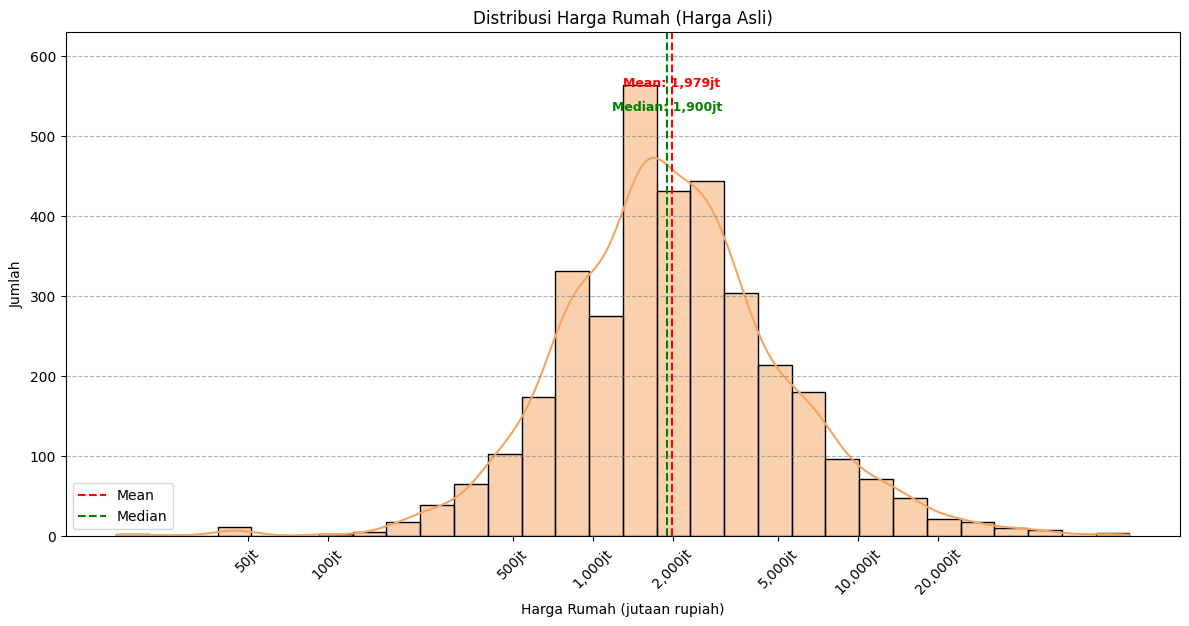

In [18]:
# Buat kolom log_harga
df['log_harga'] = np.log1p(df['Harga'])

# Buat figure
plt.figure(figsize=(12, 6))

# Plot histogram log harga dengan KDE
ax = sns.histplot(df['log_harga'], bins=30, kde=True, color='sandybrown')

# Tentukan label-label harga yang ingin ditampilkan (dalam Rupiah)
harga_asli = [5e7, 1e8, 5e8, 1e9, 2e9, 5e9, 1e10, 2e10]  # 50jt s/d 20M
log_tick = np.log1p(harga_asli)  # Konversi ke log

# Pasang posisi dan label sumbu X
ax.set_xticks(log_tick)
ax.set_xticklabels([f'{int(h/1e6):,}jt' for h in harga_asli])  # Format seperti 100jt, 500jt, dst

# Tambahkan garis mean dan median log harga
mean_log = df['log_harga'].mean()
median_log = df['log_harga'].median()

# Label untuk Mean
plt.text(mean_log, plt.ylim()[1]*0.95, f'Mean: {int(np.expm1(mean_log)/1e6):,}jt',
         color='red', ha='center', fontsize=9, fontweight='bold')

# Label untuk Median
plt.text(median_log, plt.ylim()[1]*0.9, f'Median: {int(np.expm1(median_log)/1e6):,}jt',
         color='green', ha='center', fontsize=9, fontweight='bold')

plt.axvline(mean_log, color='red', linestyle='--', label='Mean')
plt.axvline(median_log, color='green', linestyle='--', label='Median')

for y in range(100, 601, 100):
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)


# Tambahkan judul dan label sumbu
plt.title('Distribusi Harga Rumah (Harga Asli)')
plt.xlabel('Harga Rumah (jutaan rupiah)')
plt.ylabel('Jumlah')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


Grafik ini menampilkan distribusi harga rumah setelah dilakukan transformasi logaritmik natural terhadap variabel harga (log_harga) untuk mengatasi distribusi yang bersifat skewed atau mencuat ke kanan. Sumbu X telah dikonversi kembali ke satuan harga asli dalam juta rupiah untuk memudahkan interpretasi.

Dari visualisasi ini, dapat terlihat bahwa sebagian besar rumah berada dalam kisaran Rp 1 hingga 2 miliar, dengan puncak frekuensi tertinggi berada di sekitar nilai tersebut.
Dua garis vertikal menunjukkan nilai rata-rata (mean) dan nilai tengah (median) dari log harga, yang setelah dikonversi kembali ke skala harga menunjukkan distribusi relatif simetris.

Transformasi log digunakan untuk menormalkan sebaran harga agar lebih sesuai dengan asumsi yang dibutuhkan oleh model prediktif seperti regresi linear, serta untuk meminimalkan pengaruh dari properti dengan harga ekstrem tinggi terhadap rata-rata dan varian.

/tmp/ipython-input-19-4267566808.py:26: RuntimeWarning: invalid value encountered in log1p
  plt.axvline(np.log1p(lower_bound), color='red', linestyle='--', label='Batas Bawah Outlier')


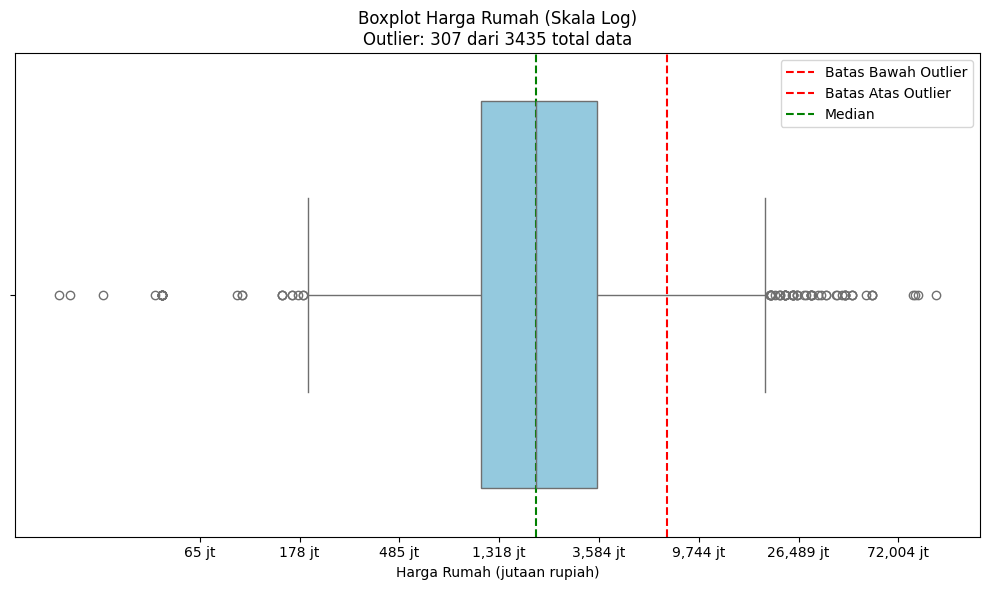

In [19]:
from matplotlib.ticker import FuncFormatter

# 1. Plot boxplot log harga
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x=df['log_harga'], color='skyblue')

# 2. Ubah label sumbu X dari log menjadi harga asli (jutaan rupiah)
ticks = [18, 19, 20, 21, 22, 23, 24, 25]
plt.xticks(
    ticks,
    [f"{int(np.expm1(t)/1e6):,} jt" for t in ticks]
)

# 3. Hitung statistik outlier (berdasarkan harga asli, bukan log)
Q1 = df['Harga'].quantile(0.25)
Q3 = df['Harga'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 4. Deteksi outlier
outliers = df[(df['Harga'] < lower_bound) | (df['Harga'] > upper_bound)]
outlier_count = len(outliers)

# 5. Tambahkan garis vertikal pada batas bawah dan atas outlier
plt.axvline(np.log1p(lower_bound), color='red', linestyle='--', label='Batas Bawah Outlier')
plt.axvline(np.log1p(upper_bound), color='red', linestyle='--', label='Batas Atas Outlier')
# Cek jika lower_bound valid untuk log1p
if lower_bound > 0:
    plt.axvline(np.log1p(lower_bound), color='red', linestyle='--', label='Batas Bawah Outlier')

# 6. Tambahkan garis untuk median
median = df['Harga'].median()
plt.axvline(np.log1p(median), color='green', linestyle='--', label='Median')

# 7. Judul dan legenda
plt.title(f'Boxplot Harga Rumah (Skala Log)\nOutlier: {outlier_count} dari {len(df)} total data')
plt.xlabel('Harga Rumah (jutaan rupiah)')
plt.legend()
plt.tight_layout()
plt.show()

Gambar di atas menunjukkan boxplot dari variabel harga rumah yang telah ditransformasi ke dalam skala logaritmik menggunakan fungsi log1p. Transformasi ini dilakukan karena distribusi harga rumah sangat tidak merata (right-skewed), dengan banyak nilai ekstrem atau outlier.

Label pada sumbu X telah dikonversi kembali ke bentuk asli harga dalam satuan jutaan rupiah untuk memudahkan interpretasi. Garis hijau menandai median harga rumah, sementara garis merah putus-putus menunjukkan batas atas dari definisi outlier yang dihitung berdasarkan metode IQR (Interquartile Range).

Berdasarkan perhitungan, terdapat 307 data (sekitar 8,9%) yang dikategorikan sebagai outlier dari total 3435 entri data. Identifikasi dan visualisasi ini menjadi penting dalam tahap prapemrosesan data sebelum melakukan proses pelatihan model, karena outlier dapat memengaruhi performa model prediksi.

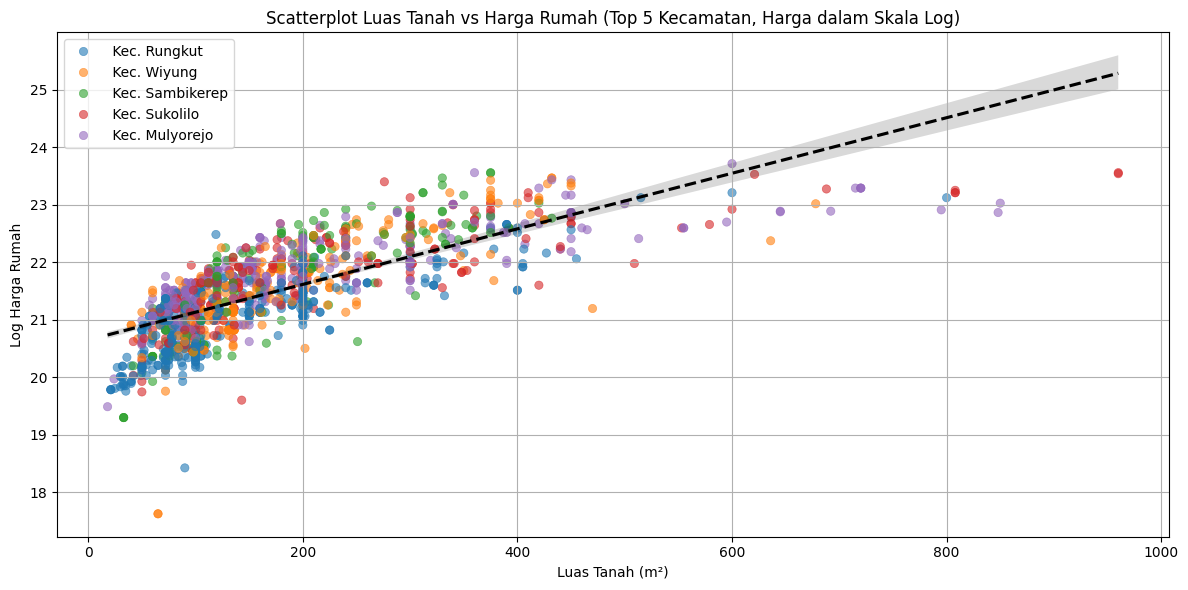

In [20]:
# 1. Filter data untuk menghindari outlier ekstrem
df_filtered = df[(df['Luas Tanah'] < 1000) & (df['Harga'] < 2e10)].copy()

# 2. Transformasi log pada variabel target
df_filtered['log_harga'] = np.log1p(df_filtered['Harga'])

# 3. Ambil 5 kecamatan terpopuler untuk hue yang lebih informatif
top_kecamatan = df_filtered['Kecamatan'].value_counts().head(5).index
df_top = df_filtered[df_filtered['Kecamatan'].isin(top_kecamatan)].copy()

# 4. Visualisasi Scatterplot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_top,
    x='Luas Tanah',
    y='log_harga',
    hue='Kecamatan',
    palette='tab10',
    alpha=0.6,
    edgecolor=None
)
# 5. Tambahkan garis regresi global
sns.regplot(
    data=df_top,
    x='Luas Tanah',
    y='log_harga',
    scatter=False,
    color='black',
    line_kws={'label': 'Garis Regresi Global', 'linestyle': 'dashed'}
)
# 6. Judul dan Label
plt.title('Scatterplot Luas Tanah vs Harga Rumah (Top 5 Kecamatan, Harga dalam Skala Log)')
plt.xlabel('Luas Tanah (m²)')
plt.ylabel('Log Harga Rumah')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Gambar ini menunjukkan hubungan antara luas tanah dan harga rumah (dalam skala logaritmik) untuk lima kecamatan dengan jumlah properti terbanyak di Surabaya. Data difilter untuk menghilangkan outlier ekstrem (luas tanah > 1000 m²). Meskipun terjadi variasi antar kecamatan, terlihat pola umum bahwa harga cenderung meningkat seiring dengan bertambahnya luas tanah, sebagaimana ditunjukkan oleh garis regresi global (garis putus-putus). Penggunaan skala logaritmik pada harga bertujuan untuk menormalkan distribusi harga yang sangat miring (skewed), sehingga hubungan linier menjadi lebih jelas terlihat. Hal ini penting sebagai dasar pemodelan regresi pada tahap selanjutnya.

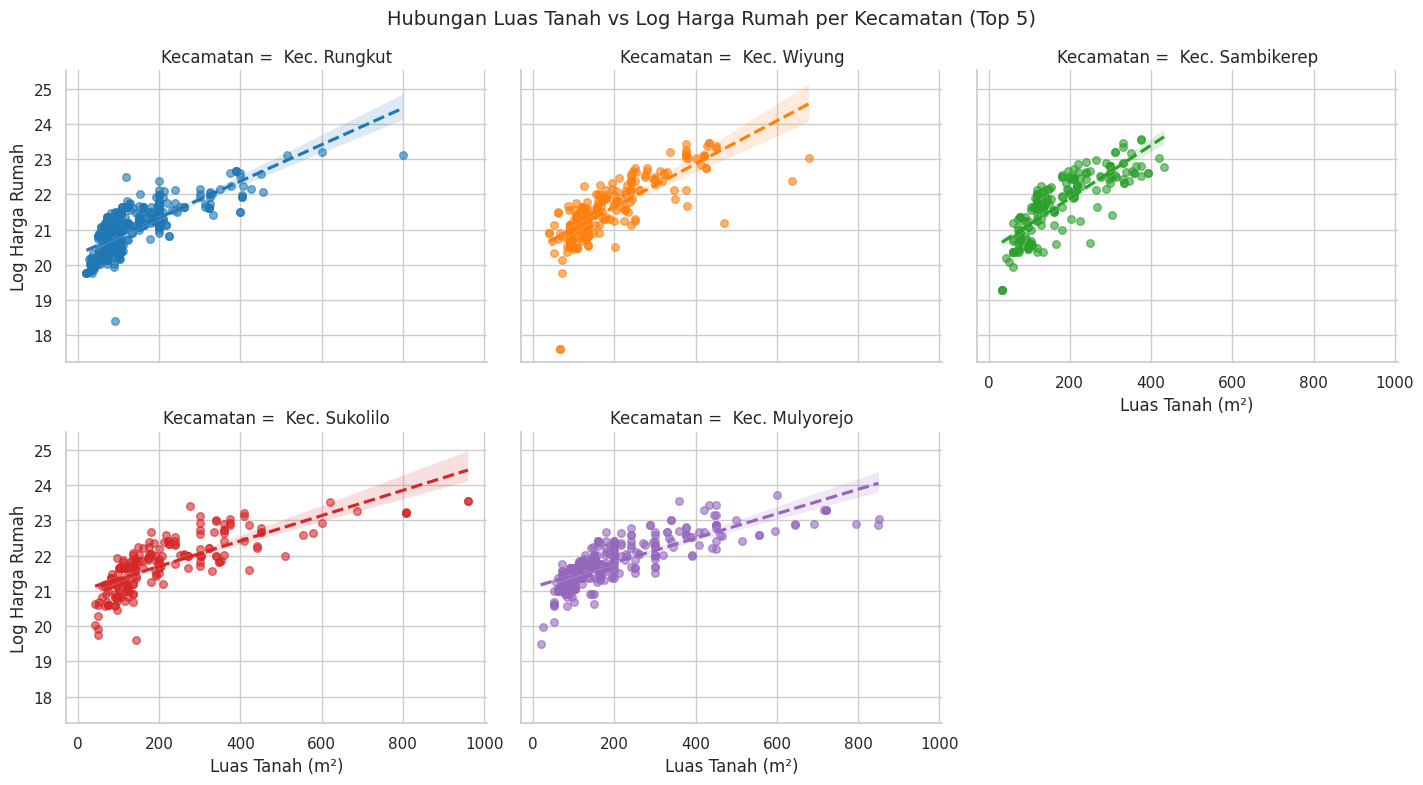

In [21]:
# 1. Filter data untuk menghindari outlier ekstrem
df_filtered = df[(df['Luas Tanah'] < 1000) & (df['Harga'] < 2e10)].copy()

# 2. Transformasi log pada variabel target
df_filtered['log_harga'] = np.log1p(df_filtered['Harga'])

# 3. Ambil 5 kecamatan terpopuler
top_kecamatan = df_filtered['Kecamatan'].value_counts().head(5).index
df_top = df_filtered[df_filtered['Kecamatan'].isin(top_kecamatan)].copy()

# 4. Buat subplot per kecamatan dengan regresi lokal
sns.set(style="whitegrid")
g = sns.lmplot(
    data=df_top,
    x='Luas Tanah',
    y='log_harga',
    hue='Kecamatan',
    col='Kecamatan',
    col_wrap=3,
    height=4,
    aspect=1.2,
    palette='tab10',
    scatter_kws={'alpha': 0.6, 's': 30},
    line_kws={'linestyle': '--'}
)

# 5. Judul global dan layout
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Hubungan Luas Tanah vs Log Harga Rumah per Kecamatan (Top 5)', fontsize=14)
g.set_axis_labels('Luas Tanah (m²)', 'Log Harga Rumah')
plt.tight_layout()
plt.show()

Gambar di atas menampilkan hubungan antara Luas Tanah dengan Log Harga Rumah untuk lima kecamatan dengan jumlah data terbanyak di Kota Surabaya. Setiap subplot merepresentasikan satu kecamatan, lengkap dengan garis regresi linier yang memperlihatkan arah dan kekuatan hubungan antara kedua variabel.

Dari hasil visualisasi ini, terlihat bahwa secara umum terdapat hubungan positif antara luas tanah dan harga rumah — semakin luas tanah, semakin tinggi harga rumah. Namun, kemiringan garis regresi (slope) bervariasi antar kecamatan, yang menunjukkan adanya perbedaan dinamika pasar properti di tiap wilayah. Misalnya, di Kecamatan Sambikerep dan Sukolilo terlihat bahwa harga rumah cenderung naik lebih cepat seiring kenaikan luas tanah dibandingkan kecamatan lainnya.

Visualisasi ini memberikan gambaran awal yang penting bahwa lokasi (kecamatan) memiliki pengaruh dalam membentuk pola harga rumah terhadap luas tanah, sehingga dapat menjadi variabel penting dalam model prediksi harga rumah.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


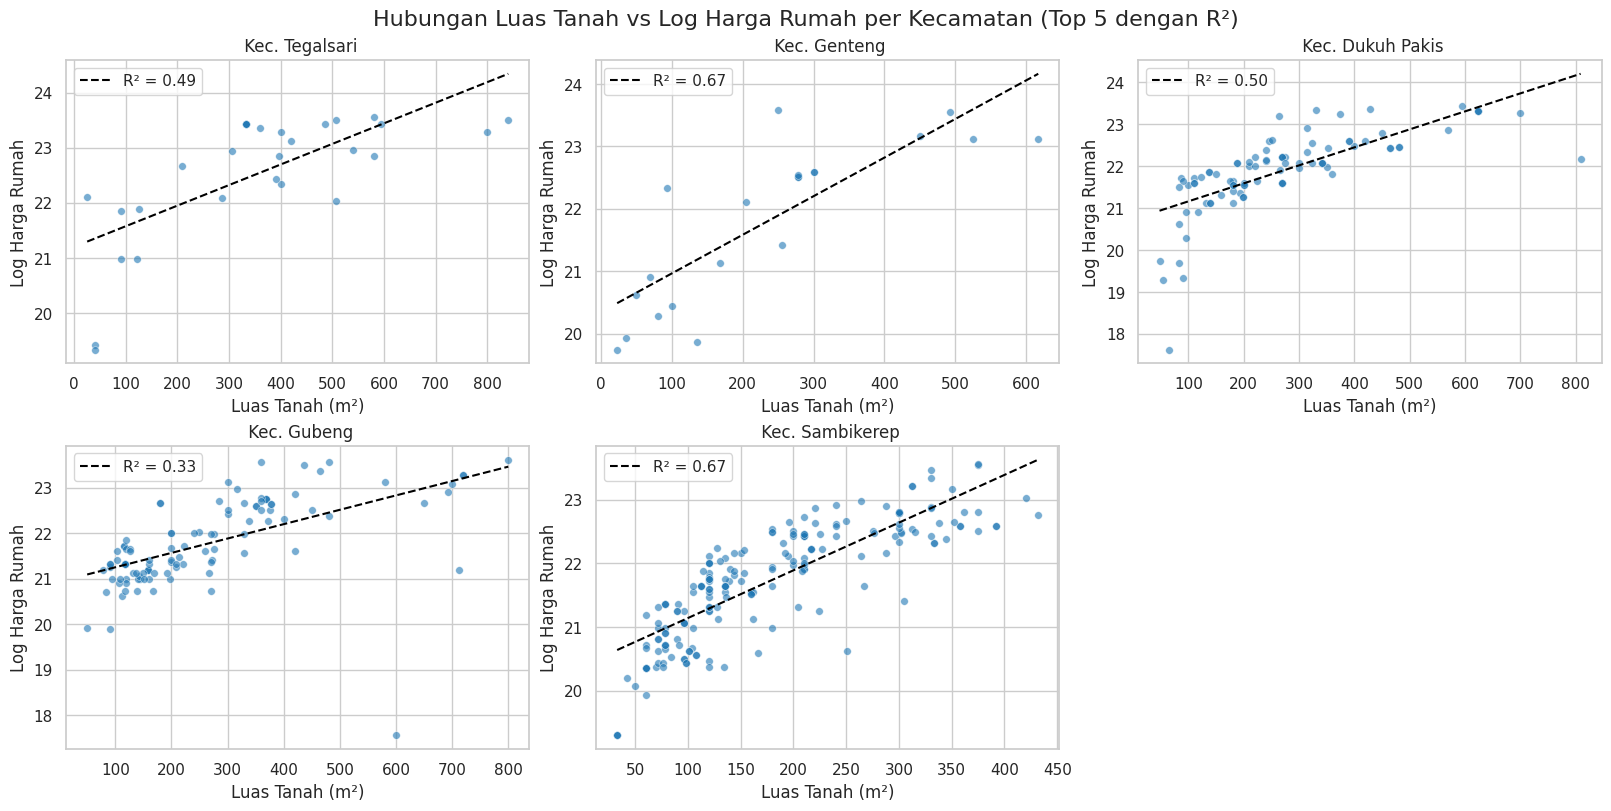

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 1. Filter data untuk menghindari outlier ekstrem
df_filtered = df[(df['Luas Tanah'] < 1000) & (df['Harga'] < 2e10)].copy()

# 2. Transformasi log pada variabel target
df_filtered['log_harga'] = np.log1p(df_filtered['Harga'])

# 3. Hitung rata-rata harga per kecamatan untuk menentukan top 5
avg_harga = df_filtered.groupby('Kecamatan')['Harga'].mean().sort_values(ascending=False)
top_kecamatan = avg_harga.head(5).index

# 4. Ambil data dari top 5 kecamatan
df_top = df_filtered[df_filtered['Kecamatan'].isin(top_kecamatan)].copy()

# 5. Siapkan subplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), constrained_layout=True)
axes = axes.flatten()

# 6. Loop tiap kecamatan
for idx, kec in enumerate(top_kecamatan):
    ax = axes[idx]
    subset = df_top[df_top['Kecamatan'] == kec]

    # Scatter
    sns.scatterplot(data=subset, x='Luas Tanah', y='log_harga', ax=ax, color='tab:blue', alpha=0.6, s=30)

    # Regressi linier
    X = subset[['Luas Tanah']]
    y = subset['log_harga']
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    # Plot garis regresi
    x_range = np.linspace(X.min(), X.max(), 100)
    y_line = model.predict(x_range)
    ax.plot(x_range, y_line, '--', color='black', label=f'R² = {r2:.2f}')

    # Label dan judul
    ax.set_title(f'{kec}')
    ax.set_xlabel('Luas Tanah (m²)')
    ax.set_ylabel('Log Harga Rumah')
    ax.legend()

# 7. Hapus subplot kosong jika ada
for i in range(len(top_kecamatan), len(axes)):
    fig.delaxes(axes[i])

# 8. Judul Global
fig.suptitle('Hubungan Luas Tanah vs Log Harga Rumah per Kecamatan (Top 5 dengan R²)', fontsize=16)
plt.show()

Scatterplot hubungan antara luas tanah dengan log harga rumah pada lima kecamatan dengan nilai koefisien determinasi (R²) tertinggi. Setiap subplot menunjukkan garis regresi linear serta nilai R² yang mengindikasikan kekuatan hubungan antara luas tanah dengan harga rumah dalam skala logaritmik. Kecamatan yang ditampilkan adalah kecamatan dengan pola hubungan yang paling kuat di antara seluruh wilayah di Surabaya.

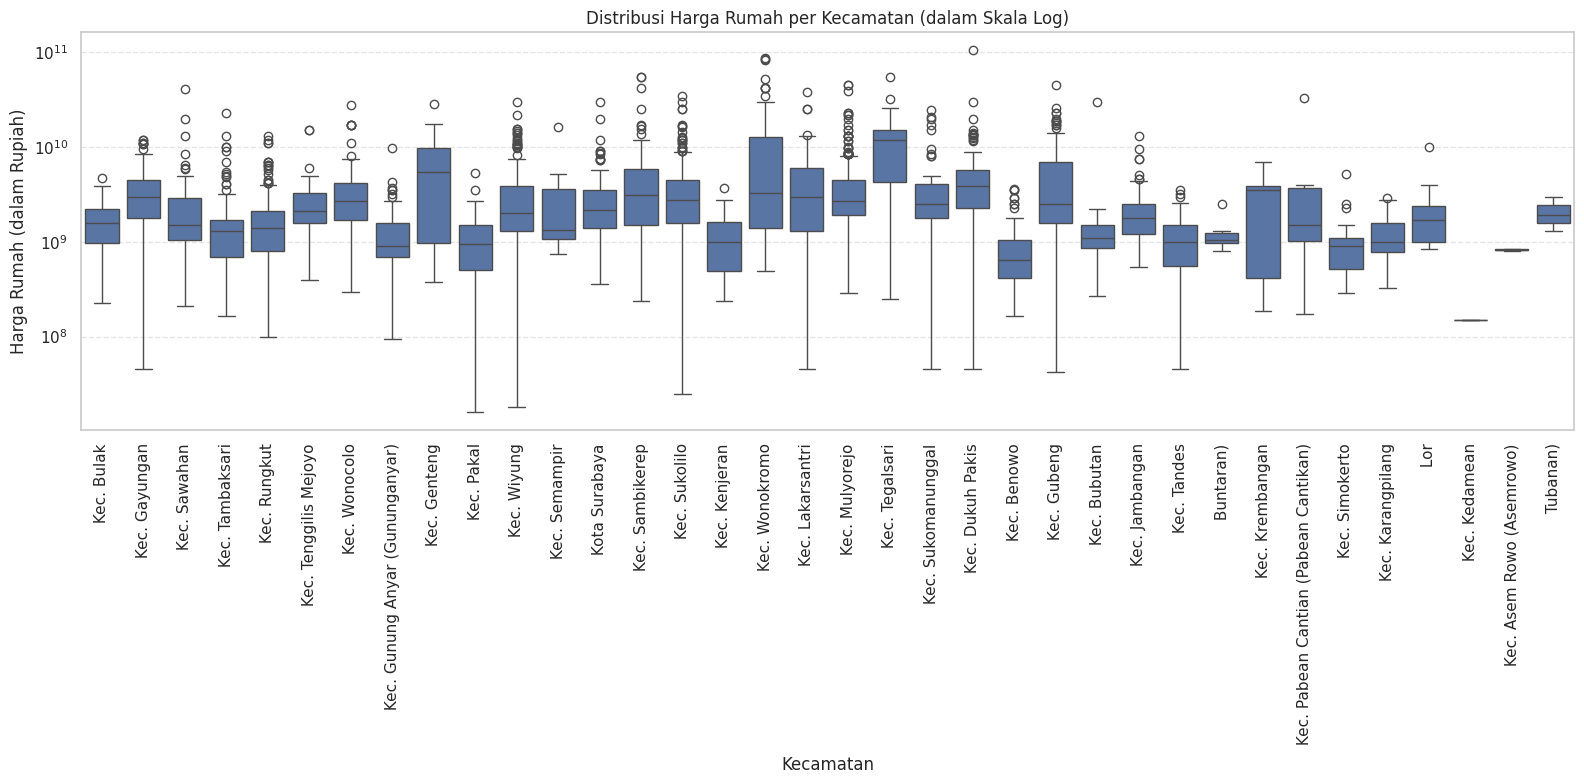

In [23]:
plt.figure(figsize=(16, 8))

# Gunakan skala log agar outlier tidak mendominasi
sns.boxplot(x='Kecamatan', y='Harga', data=df, showfliers=True)
plt.xticks(rotation=90)

# Format sumbu Y ke jutaan/miliar
plt.ylabel('Harga Rumah (dalam Rupiah)')
plt.xlabel('Kecamatan')
plt.yscale('log')  # Gunakan skala log agar distribusi lebih terlihat
plt.title('Distribusi Harga Rumah per Kecamatan (dalam Skala Log)')

# Tambahkan grid horizontal untuk referensi
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Visualisasi boxplot distribusi harga rumah berdasarkan kecamatan di Kota Surabaya. Skala log digunakan untuk mengurangi dominasi nilai ekstrem (outlier) sehingga distribusi harga di sebagian besar kecamatan dapat terlihat lebih jelas.

Terlihat bahwa sebagian besar kecamatan memiliki median harga rumah dalam rentang yang relatif serupa, namun terdapat perbedaan signifikan pada sebaran data dan jumlah outlier. Kecamatan seperti Tegalsari, Wonokromo, dan Genteng menunjukkan persebaran harga yang jauh lebih tinggi, bahkan memiliki outlier dengan harga yang sangat ekstrem.

Temuan ini menunjukkan bahwa walaupun harga rumah bisa serupa secara median antar kecamatan, namun variasi internal di dalam tiap kecamatan bisa sangat tinggi, dan hal ini perlu dipertimbangkan dalam pemodelan prediktif, terutama untuk algoritma yang sensitif terhadap outlier.

/tmp/ipython-input-24-2909554481.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


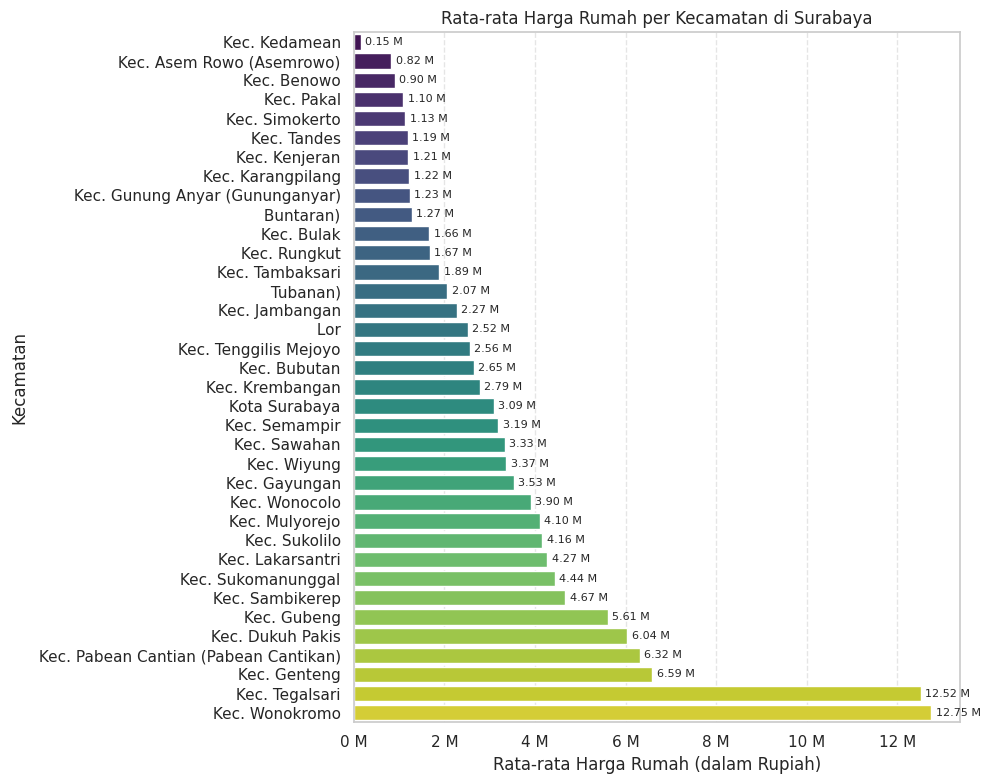

In [24]:
# Hitung rata-rata harga rumah per kecamatan
mean_prices = df.groupby('Kecamatan')['Harga'].mean().sort_values()

# Buat barplot horizontal dengan warna berdasarkan nilai
plt.figure(figsize=(10, 8))
sns.barplot(
    y=mean_prices.index,
    x=mean_prices.values,
    palette='viridis'
)

# Format sumbu X ke format jutaan rupiah
plt.xlabel('Rata-rata Harga Rumah (dalam Rupiah)')
plt.ylabel('Kecamatan')
plt.title('Rata-rata Harga Rumah per Kecamatan di Surabaya')
plt.xticks(
    ticks=[i * 1e9 for i in range(0, 14, 2)],
    labels=[f'{int(i)} M' for i in range(0, 14, 2)]
)

# Tambahkan label nilai pada ujung bar (opsional)
for i, value in enumerate(mean_prices.values):
    plt.text(value + 1e8, i, f'{value/1e9:.2f} M', va='center', fontsize=8)

plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

Visualisasi rata-rata harga rumah di setiap kecamatan di Kota Surabaya. Tampak bahwa Kecamatan Wonokromo, Tegalsari, dan Genteng menempati posisi tiga teratas dengan rata-rata harga rumah tertinggi, yaitu di atas 10 miliar rupiah. Hal ini dapat mencerminkan lokasi-lokasi strategis yang memiliki nilai komersial tinggi atau berada di pusat kota.

Sebaliknya, kecamatan seperti Kedamean, Asem Rowo, dan Pakal memiliki rata-rata harga rumah paling rendah. Visualisasi ini memberikan gambaran penting mengenai distribusi harga antar wilayah dan dapat menjadi dasar dalam menentukan segmentasi pasar atau area fokus pembangunan perumahan.

Grafik ini juga memperlihatkan ketimpangan distribusi harga antar kecamatan, yang dapat mempengaruhi model prediksi apabila variabel lokasi tidak dimasukkan secara tepat. Oleh karena itu, atribut Kecamatan sebaiknya dipertimbangkan sebagai variabel kategorikal penting dalam proses modeling.

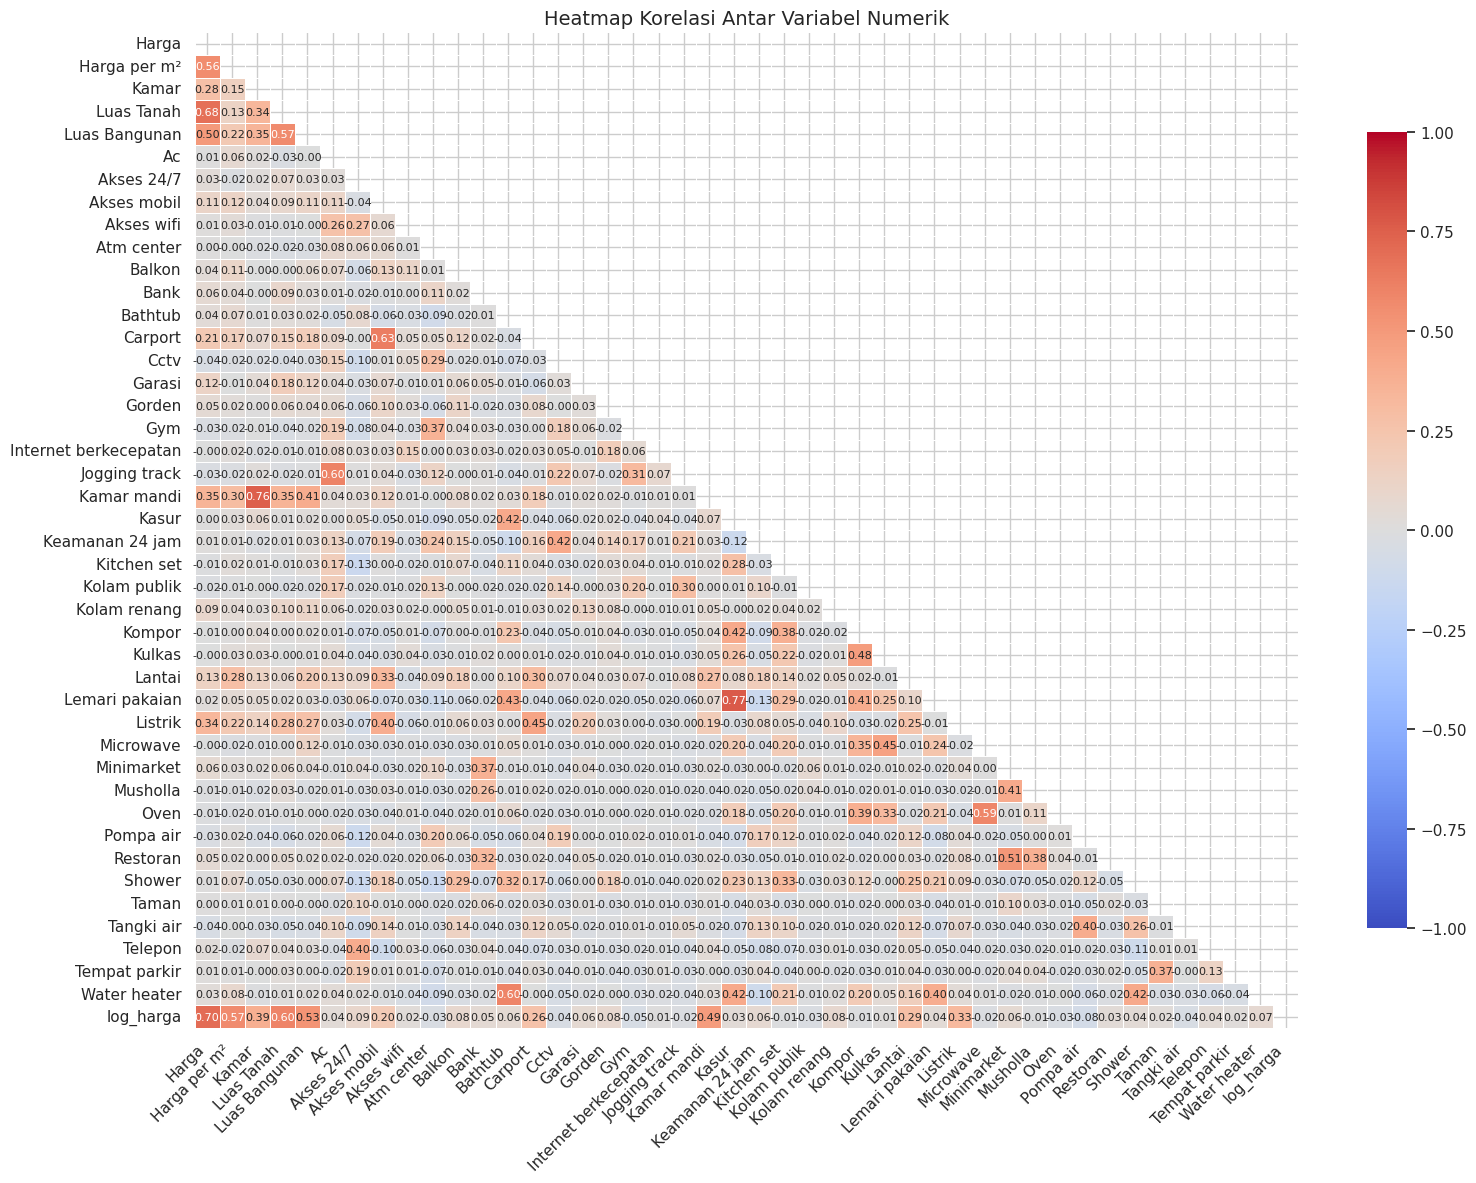

In [25]:
# Hitung korelasi hanya untuk numerik
corr = df.corr(numeric_only=True)

# Buat mask untuk bagian atas (karena matriks simetris)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Ukuran figure yang lebih besar agar teks terbaca
plt.figure(figsize=(16, 12))

# Buat heatmap dengan anotasi yang lebih bersih
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 8}
)

plt.title("Heatmap Korelasi Antar Variabel Numerik", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Heatmap korelasi antar variabel numerik dalam dataset properti rumah di Surabaya. Warna biru menunjukkan korelasi negatif, sedangkan warna merah menunjukkan korelasi positif, dengan intensitas warna menandakan kekuatan hubungan antar variabel.

Berdasarkan visualisasi, variabel Harga memiliki korelasi paling kuat terhadap variabel Luas Bangunan (r=0.57), diikuti oleh Luas Tanah (r=0.52) dan Jumlah Kamar (r=0.33). Hal ini menunjukkan bahwa ketiga variabel tersebut merupakan faktor utama yang mempengaruhi harga rumah, dan dapat dijadikan fitur utama dalam model prediksi.

Sementara itu, sebagian besar variabel fasilitas (seperti Kolam Publik, Restoran, atau CCTV) menunjukkan korelasi lemah terhadap harga, menandakan bahwa kehadiran fasilitas tersebut bersifat opsional dan tidak selalu mencerminkan harga pasar.

Temuan ini memberikan arah bagi proses feature selection, di mana hanya variabel dengan korelasi moderat hingga kuat terhadap target (Harga) yang sebaiknya dipertahankan untuk membangun model prediktif yang lebih efektif.

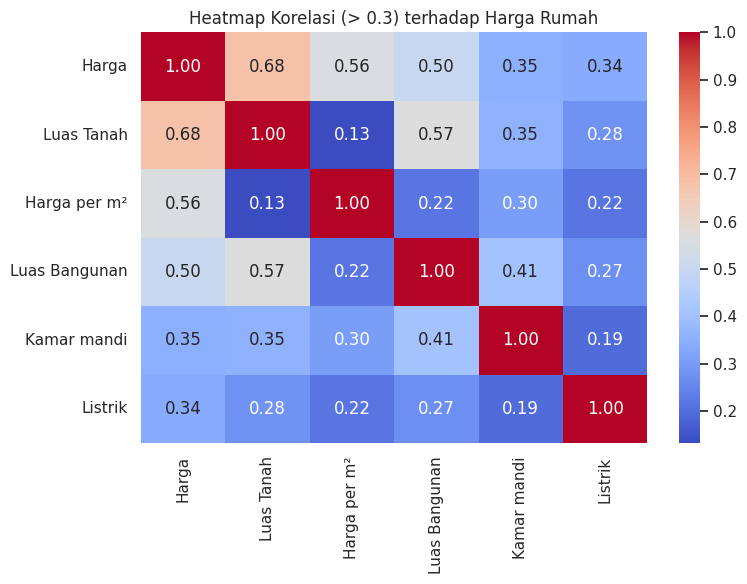

In [26]:
# Hitung korelasi hanya untuk kolom numerik
corr_matrix = df.corr(numeric_only=True)

# Ambil korelasi terhadap kolom 'Harga' saja
harga_corr = corr_matrix['Harga'].drop('Harga')

# Filter fitur yang korelasinya > 0.3 atau < -0.3
selected_features = harga_corr[abs(harga_corr) > 0.3]

# Urutkan berdasarkan korelasi tertinggi ke terendah
sorted_features = selected_features.sort_values(ascending=False).index

# Susun ulang urutan kolom: Harga + fitur terurut
ordered_columns = ['Harga'] + list(sorted_features)

# Ambil sub-korelasi
selected_corr = df[ordered_columns].corr()

# Buang 'log_harga' dari heatmap jika ada
selected_corr = selected_corr.drop(columns='log_harga', errors='ignore')
selected_corr = selected_corr.drop(index='log_harga', errors='ignore')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(selected_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi (> 0.3) terhadap Harga Rumah')
plt.tight_layout()
plt.show()

Analisis korelasi dilakukan untuk memahami hubungan linier antara variabel numerik yang terdapat dalam dataset terhadap variabel target, yaitu Harga Rumah. Korelasi dihitung menggunakan koefisien Pearson yang menghasilkan nilai antara -1 hingga 1, di mana nilai mendekati 1 menunjukkan hubungan positif yang kuat, dan nilai mendekati -1 menunjukkan hubungan negatif yang kuat.

Gambar menampilkan heatmap korelasi antar variabel numerik yang memiliki koefisien korelasi terhadap harga rumah lebih dari 0.3. Visualisasi ini bertujuan untuk membantu dalam proses seleksi fitur yang relevan guna keperluan pemodelan prediktif.

Berdasarkan hasil visualisasi, diperoleh beberapa temuan penting sebagai berikut:

Luas Tanah (r = 0.68)
Variabel luas tanah menunjukkan korelasi tertinggi terhadap harga rumah. Hal ini menunjukkan bahwa semakin besar luas tanah yang dimiliki, maka cenderung diikuti oleh peningkatan harga rumah. Secara umum, nilai lahan seringkali menjadi komponen utama dalam penentuan harga properti, sehingga hasil ini cukup sejalan dengan kondisi pasar riil.

Harga per meter persegi (r = 0.56)
Terdapat korelasi yang cukup kuat antara harga per m² dengan harga rumah secara keseluruhan. Artinya, rumah-rumah dengan harga satuan tanah dan bangunan yang lebih mahal juga cenderung memiliki harga total yang lebih tinggi.

Luas Bangunan (r = 0.50)
Luas bangunan juga memberikan kontribusi signifikan terhadap harga rumah. Rumah dengan bangunan yang lebih besar umumnya memerlukan biaya konstruksi yang lebih tinggi dan menyediakan lebih banyak ruang, yang berkontribusi pada kenaikan harga.

Jumlah Kamar Mandi (r = 0.35)
Meskipun tidak sebesar variabel sebelumnya, jumlah kamar mandi memiliki korelasi positif sedang terhadap harga. Hal ini menunjukkan bahwa fasilitas tambahan seperti kamar mandi turut memberikan nilai tambah terhadap rumah, terutama dalam konteks kenyamanan dan fungsi.

Daya Listrik (r = 0.34)
Daya listrik pada rumah menunjukkan korelasi yang relatif sedang. Rumah dengan kapasitas daya listrik yang lebih besar umumnya ditujukan untuk kebutuhan rumah tangga modern yang menggunakan peralatan elektronik dalam jumlah besar, sehingga turut menjadi indikator kelengkapan fasilitas rumah.

Selain itu, terdapat pula korelasi antar fitur yang cukup menonjol, seperti antara luas bangunan dan luas tanah (r = 0.57), yang mengindikasikan bahwa rumah-rumah dengan lahan luas cenderung memiliki bangunan yang juga besar. Korelasi serupa juga terlihat antara kamar mandi dan luas bangunan (r = 0.41), yang menggambarkan bahwa rumah dengan ukuran besar biasanya menyediakan lebih dari satu kamar mandi.

Berdasarkan hasil korelasi ini, fitur-fitur dengan koefisien korelasi lebih dari 0.3 terhadap harga rumah dipertimbangkan sebagai kandidat utama untuk proses pemodelan prediktif. Pemilihan ini dilakukan dengan pertimbangan bahwa fitur-fitur tersebut memiliki pengaruh yang cukup signifikan dalam menjelaskan variasi harga rumah.



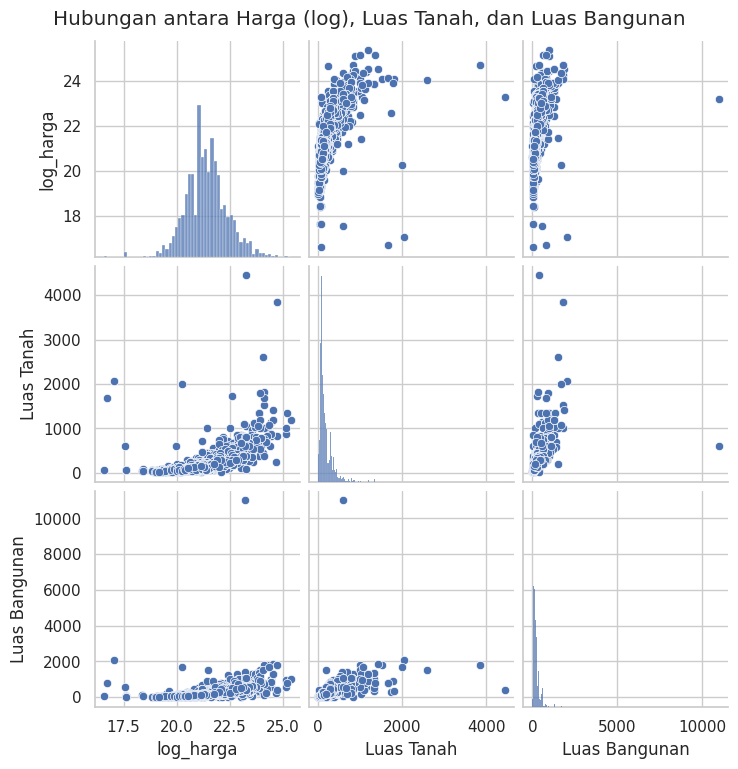

In [27]:
df['log_harga'] = np.log1p(df['Harga'])
sns.pairplot(df[['log_harga', 'Luas Tanah', 'Luas Bangunan']])
plt.suptitle("Hubungan antara Harga (log), Luas Tanah, dan Luas Bangunan", y=1.02)
plt.show()


Visualisasi ini memperlihatkan hubungan antar tiga variabel utama dalam dataset properti, yaitu logaritma harga rumah, luas tanah, dan luas bangunan. Pairplot ini memberikan gambaran menyeluruh mengenai distribusi masing-masing variabel serta hubungan korelasional antar dua variabel secara bersamaan melalui scatter plot dan histogram.

Terlihat bahwa hubungan antara logaritma harga rumah dengan luas tanah serta dengan luas bangunan menunjukkan pola distribusi yang meningkat, mengindikasikan adanya korelasi positif. Artinya, secara umum, semakin luas tanah atau bangunan, semakin tinggi pula harga rumah. Namun, korelasi ini tidak sepenuhnya linier, terutama pada nilai-nilai ekstrem, yang terlihat dari penyebaran data yang cukup lebar di bagian tertentu.

Distribusi dari variabel Luas Tanah dan Luas Bangunan juga menunjukkan skewness ke kanan (right-skewed), menandakan bahwa sebagian besar rumah memiliki ukuran tanah dan bangunan yang relatif kecil, sementara hanya sebagian kecil yang memiliki ukuran sangat besar. Hal ini penting untuk diperhatikan karena nilai-nilai ekstrem dapat mempengaruhi model prediktif yang akan dibangun.

Visualisasi ini memberikan insight awal yang penting tentang hubungan dan distribusi antar fitur utama, sehingga dapat menjadi dasar dalam proses eksplorasi data lanjutan maupun pemilihan fitur untuk model prediksi harga rumah.

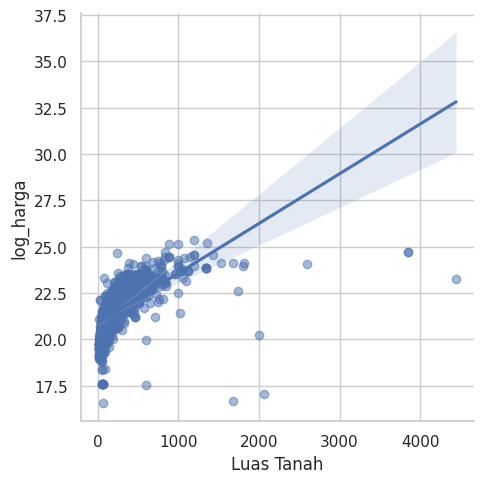

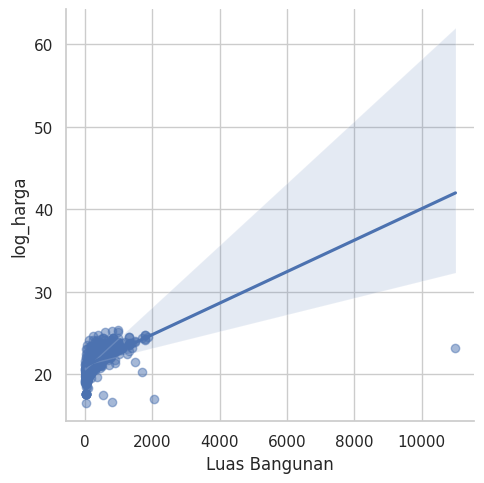

In [30]:
sns.lmplot(data=df, x='Luas Tanah', y='log_harga', scatter_kws={'alpha':0.5})
sns.lmplot(data=df, x='Luas Bangunan', y='log_harga', scatter_kws={'alpha':0.5})


Visualisasi ini menampilkan dua plot regresi linier yang masing-masing menggambarkan hubungan antara luas tanah terhadap logaritma harga rumah, dan luas bangunan terhadap logaritma harga rumah. Dibandingkan dengan pairplot pada versi 1, visualisasi ini lebih fokus pada hubungan linier antar dua variabel dengan garis regresi dan interval kepercayaan.

Kedua plot menunjukkan tren positif yang jelas, menguatkan temuan sebelumnya bahwa baik luas tanah maupun luas bangunan memiliki pengaruh positif terhadap harga rumah. Namun demikian, rentang interval kepercayaan yang cukup lebar pada nilai ekstrim menunjukkan adanya variabilitas yang tinggi serta kemungkinan outlier yang dapat mempengaruhi kestabilan model.

Plot ini berguna untuk memvisualisasikan dan mengevaluasi asumsi linieritas dalam konteks prediktif. Secara khusus, ia dapat membantu dalam pemilihan dan pengujian model regresi yang lebih sesuai terhadap data yang ada.

## GENERATE AI FOR INSIGHTS

In [ ]:
!pip install langchain_community
!pip install Replicate
!pip install -U langchain langchain-community langchain-experimental replicate

In [52]:
from langchain_experimental.agents.agent_toolkits.pandas.base import (
    create_pandas_dataframe_agent
)
from langchain_community.llms import Replicate
from google.colab import userdata
import os
import replicate

# Ambil API token
api_token = userdata.get("api_token")
os.environ["REPLICATE_API_TOKEN"] = api_token

# ===================== #
# 📊 LOAD DATASET       #
# ===================== #
url = "https://raw.githubusercontent.com/dimasfajrip/capstone_project_ibmXhacktiv8/main/dataset_new_clean.csv"
df = pd.read_csv(url)

# ===================== #
# ⚙️ REPLICATE CONFIG   #
# ===================== #
parameters = {
    "max_tokens": 1024,
    "temperature": 0.65,
    "top_p": 0.9,
    "top_k": 50,
    "repetition_penalty": 1.1,
}

def ask_granite(prompt: str):
    output = replicate.run(
        "ibm-granite/granite-3.3-8b-instruct",
        input={"prompt": prompt, **parameters}
    )
    return "".join(output)

Prompt ini digunakan untuk memperoleh pemahaman awal mengenai distribusi data dalam dataset, terutama terhadap atribut-atribut kunci seperti harga, luas tanah, dan jumlah kamar. Statistik deskriptif membantu mengidentifikasi pola umum, outlier, serta rentang nilai dari setiap fitur. Ini merupakan langkah dasar yang krusial dalam setiap proses eksplorasi data (Exploratory Data Analysis / EDA).

In [53]:
prompt_1 = f"""
The following is a statistical summary of a housing dataset from Surabaya. Please extract meaningful insights from the distribution of house prices, land area, building size, and number of bedrooms:

Summary statistics:
{df.describe().to_string()}
"""

print(ask_granite(prompt_1))


Based on the provided statistical summary of the Surabaya housing dataset, here are some meaningful insights:

1. **House Prices (Harga):** 
   - The mean house price is approximately 3.34 x 10^9 Indonesian Rupiah (around $234,000 USD).
   - The median house price (50% percentile) is 1.9 x 10^9 Rupiah (approximately $132,000 USD).
   - The price range spans from 1.6 x 10^7 Rupiah (about $11,000 USD) to 1.05 x 10^11 Rupiah (around $73.3 million USD), indicating a diverse market with properties catering to different budgets.
   - The standard deviation of house prices is 5.51 x 10^9 Rupiah (approximately $384,000 USD), reflecting significant variation among properties.

2. **Price per Square Meter (Harga per m²):** 
   - The mean price per square meter is 1.598581 x 10^7 Rupiah (around $11,150 USD).
   - The median price per square meter is 1.44 x 10^7 Rupiah (approximately $9,900 USD).
   - This indicates that Surabaya's housing market has a relatively high price per square meter, refle

Prompt ini bertujuan untuk memahami hubungan antar variabel numerik dalam dataset, khususnya mencari tahu fitur mana yang paling berkorelasi dengan harga rumah. Interpretasi korelasi penting dalam konteks pengambilan keputusan berbasis data, misalnya untuk menentukan fitur utama yang memengaruhi nilai properti. Hasil ini dapat mendasari strategi harga atau pengembangan produk oleh developer.

In [54]:
correlations = df.corr(numeric_only=True)['Harga'].sort_values(ascending=False)

prompt_2 = f"""
I have computed the correlation between house features and price in a dataset of properties in Surabaya. Please help analyze the correlations to identify which features most influence house prices and why.

Here is the correlation data:
{correlations.to_string()}
"""

print(ask_granite(prompt_2))

Based on the provided correlation data, here's an analysis of the features most influencing house prices in Surabaya:

1. **log_Harga (logarithm of price)**: With a correlation of 1.000000 with Harga (price), it indicates a perfect positive relationship between the natural logarithm of the price and the price itself. This variable is essentially a transformed version of the target variable (price) and doesn't represent an independent feature.

2. **Luas Tanah (Land area)**: The highest correlation (0.683846) with the price suggests that the land area significantly influences house prices. Larger land areas generally command higher prices.

3. **Harga per m² (Price per square meter)**: With a correlation of 0.558633, this feature indicates how much the price increases for each additional square meter of the property. A higher value implies that the property's price escalates more rapidly with each additional square meter.

4. **Luas Bangunan (Building area)**: Having a correlation of 0.

Analisis anomali diperlukan untuk mengidentifikasi rumah dengan harga yang tidak wajar terhadap atribut fisiknya (misal: rumah kecil tapi mahal). Prompt ini berguna untuk mengungkap faktor-faktor non-teknis atau tersembunyi yang memengaruhi harga, seperti lokasi premium, fasilitas unik, atau kesalahan entri data. Ini juga mendukung validasi dan pembersihan data.

In [55]:
prompt_3 = """
Some houses in my dataset are very expensive despite having small building sizes, and some cheap houses have larger areas. What might explain this anomaly? Which features could justify such price outliers? Suggest a logical approach to detect and explain these cases.
"""

print(ask_granite(prompt_3))

This anomaly in your housing dataset, where smaller houses are priced higher than larger ones, can be attributed to several factors. Here are some features and a logical approach to identify and explain these outliers:

1. **Location**: High-priced neighborhoods or areas with exclusive zip codes, proximity to city centers, or scenic views can justify higher prices despite smaller sizes. 

2. **Property Quality**: High-end finishes, architectural design, or unique features (like a pool, garden, custom-built, etc.) could increase the value disproportionately to the size. 

3. **Historical Significance**: Older, historically important houses might be smaller but command higher prices due to their heritage or unique status.

4. **Lot Size**: Even though the building size is small, a large lot with privacy, landscaping, or outdoor amenities can inflate the price.

5. **View**: Houses with exceptional views (like ocean, mountain, or cityscape) often sell for more per square foot than similar

Properti sangat dipengaruhi oleh lokasi geografis. Prompt ini digunakan untuk menggali wawasan berdasarkan perbedaan harga rumah antar kecamatan di Surabaya. Analisis spasial seperti ini penting dalam memahami dinamika pasar lokal, potensi investasi, dan perencanaan pembangunan. Ini juga membantu menyusun strategi pemasaran yang disesuaikan dengan konteks wilayah.

In [56]:
prompt_4 = """
There is a significant variation in house prices between districts such as Kec. Sawahan and Kec. Gayungan in Surabaya. Please analyze how location might affect house prices and how local facilities or urban characteristics may contribute to this difference. Provide insight related to strategic locations and price trends.
"""

print(ask_granite(prompt_4))


House prices in urban areas like Surabaya, East Java, Indonesia, can vary significantly between different districts such as Kecamatan Sawahan and Kecamatan Gayungan. This variation is primarily influenced by several factors related to location, local facilities, and urban characteristics. Here's an analysis of how these elements contribute to the price differences:

1. **Proximity to Central Business District (CBD) and Employment Hubs**: Kecamatan Gayungan might be closer to the CBD or major employment centers, making it more desirable for professionals and businesses. This proximity typically drives up house prices due to higher demand and convenience. Conversely, Kecamatan Sawahan, if located further from these hubs, might experience lower prices due to lesser demand and inconvenience.

2. **Infrastructure and Accessibility**: Good road networks, public transportation links, and easy access to main highways or airports can significantly increase property values. If Gayungan has bette

Prompt ini berfungsi untuk menyarikan hasil temuan dari berbagai analisis ke dalam bentuk insight yang komprehensif dan naratif. Ringkasan ini menjadi jembatan antara data mentah dan keputusan strategis. Penyusunan insight mendalam penting dalam konteks komunikasi data kepada pemangku kepentingan non-teknis agar keputusan bisa diambil secara informasional.

In [57]:
prompt_5 = """
Please summarize the following findings into an analytical insight:

- The top features most correlated with house prices are: building_size (0.78), number_of_bathrooms (0.65), and carport (0.59)
- District Tambaksari has the highest average house price
- Most houses lack AC, microwave, or bathtub
- Carport and garden significantly increase property value
- Houses under IDR 500 million typically lack additional facilities

Write a clear and structured summary in 2 to 3 analytical paragraphs.
"""

print(ask_granite(prompt_5))


The analysis of house price determinants reveals several key insights into the real estate market. The most influential features correlating with higher house prices are building size, the number of bathrooms, and the presence of a carport. Building size, with a correlation coefficient of 0.78, demonstrates a strong positive relationship, indicating that larger homes command higher prices. The number of bathrooms (0.65) also significantly impacts pricing, reflecting modern homebuyer preferences for multiple bath facilities. Surprisingly, the mere presence of a carport, correlating at 0.59, contributes positively to a property's value, suggesting that this feature is more valued than commonly assumed. 

Geographically, Tambaksari district stands out with the highest average house prices, implying that location-specific factors, possibly including amenities, infrastructure, or local demand, play a crucial role in pricing beyond the basic features. Conversely, the prevalence of houses lac

Rekomendasi berbasis data adalah tujuan akhir dari proses analitik. Prompt ini digunakan untuk menghasilkan saran konkret dan aplikatif yang relevan bagi tiga kelompok utama: pengembang, pembeli pertama, dan investor properti. Pendekatan ini menunjukkan penerapan langsung dari temuan analitik dalam konteks dunia nyata dan mendemonstrasikan dampak praktis dari data science.

In [58]:
prompt_6 = """
Based on insights from housing data in Surabaya, please provide specific and actionable recommendations for the following groups:

1. Residential developers
2. First-time home buyers
3. Property investors

Ensure the recommendations are based on the patterns observed in the data.
"""

print(ask_granite(prompt_6))


1. Residential Developers:

Based on the housing data in Surabaya, here are specific recommendations for residential developers:

- **Focus on Affordable Housing**: The demand for affordable housing in Surabaya is high, particularly in areas like Kota Tubun, Gubeng, and Sawahan. Developers should prioritize building mid- to low-priced housing projects to cater to the growing middle class and lower-income segments.

- **Sustainable Developments**: With increasing environmental awareness, incorporating green building practices can attract eco-conscious buyers. Implementing energy-efficient designs, water-saving fixtures, and waste management systems can enhance property value and appeal.

- **Strategic Location**: Developments near essential facilities such as schools, hospitals, shopping centers, and public transportation hubs will be in high demand. Consider investing in areas with upcoming infrastructure improvements and expansions, like the Surabaya Mercure Area, which is expected to

Dalam proyek berbasis AI, penting untuk menjelaskan bagaimana model LLM (Large Language Model) digunakan. Prompt ini difungsikan untuk mendokumentasikan peran IBM Granite dalam proses analisis, termasuk dalam interpretasi data, ekstraksi insight, dan pembuatan rekomendasi. Dokumentasi ini memenuhi prinsip transparansi dan replikasi dalam penelitian berbasis AI.

In [59]:
prompt_7 = """
IBM Granite LLM was used to support a data analysis project involving housing prices in Surabaya. It was applied to:

- Convert statistical summaries into readable insights
- Interpret correlations between features and price
- Generate data-driven recommendations
- Detect anomalies and pricing outliers

Please write a professional explanation of how this AI model supported the data analysis process. Use the tone of an academic or data science project report.
"""

print(ask_granite(prompt_7))


Title: Leveraging IBM Granite LLM for Comprehensive Housing Price Analysis in Surabaya

Abstract:
This report elucidates the application of IBM Granite Large Language Model (LLM) in a data analysis project focused on housing prices in Surabaya. The AI model was instrumental in transforming raw statistical data into actionable insights, interpreting feature correlations with property prices, generating data-driven recommendations, and identifying pricing anomalies and outliers. The integration of Granite LLM facilitated a nuanced understanding of the Surabaya housing market, contributing to informed decision-making and policy formulation.

1. Introduction

The study aimed to analyze housing prices in Surabaya, Indonesia, by employing advanced natural language processing (NLP) techniques through the IBM Granite LLM. This AI model's capacity to comprehend and generate human-like text enabled it to navigate and interpret complex datasets, offering valuable insights into the housing market 

Segmentasi pasar berdasarkan harga adalah pendekatan klasik dalam strategi pemasaran dan pengembangan produk. Prompt ini digunakan untuk mengelompokkan rumah menjadi kategori harga rendah, menengah, dan tinggi, serta mengidentifikasi karakteristik khas masing-masing. Segmentasi membantu dalam pemahaman kebutuhan konsumen dan alokasi sumber daya pemasaran.

In [60]:
prompt_8 = """
I would like to segment the housing data in Surabaya into three categories: low-cost, mid-range, and high-end. Please help define logical price boundaries for each category and describe the typical features found in each segment.
"""

print(ask_granite(prompt_8))


To segment the housing data in Surabaya into low-cost, mid-range, and high-end categories, we need to establish logical price boundaries based on the local market context and typical features for each segment. Here's a proposed framework:

1. **Low-Cost Segment:**
   - **Price Boundaries:** Rp. 50,000,000 - Rp. 150,000,000 (approximately USD 35,000 - USD 105,000)
   - **Typical Features:**
     - Smaller living spaces (1-2 bedrooms, 30-60 sqm)
     - Basic amenities: minimal built-in kitchen appliances, simple bathroom fixtures
     - Located in less central, newer residential areas or redeveloping neighborhoods
     - May lack private parking or green spaces
     - Target demographic: young professionals, students, or first-time homebuyers on a budget

2. **Mid-Range Segment:**
   - **Price Boundaries:** Rp. 150,000,000 - Rp. 300,000,000 (approximately USD 105,000 - USD 210,000)
   - **Typical Features:**
     - Larger living spaces (2-3 bedrooms, 60-120 sqm)
     - Improved amenities


Segmentasi pasar berdasarkan harga adalah pendekatan klasik dalam strategi pemasaran dan pengembangan produk. Prompt ini digunakan untuk mengelompokkan rumah menjadi kategori harga rendah, menengah, dan tinggi, serta mengidentifikasi karakteristik khas masing-masing. Segmentasi membantu dalam pemahaman kebutuhan konsumen dan alokasi sumber daya pemasaran.

In [61]:
prompt_9 = """
If a developer adds a swimming pool and a kitchen set to a two-bedroom house, how much could the price increase based on the dataset trends? Please give a logical estimation or insight based on common patterns in real estate.
"""

print(ask_granite(prompt_9))


To provide a logical estimation for the price increase when a swimming pool and a kitchen set are added to a two-bedroom house, we need to consider typical real estate market trends and additional features' impact on property value. 

1. **Swimming Pool**: Adding a swimming pool generally increases a home's value, but the extent varies based on location, size, and maintenance costs. According to various real estate studies, a standard in-ground pool can add approximately 6-12% to a home's value. However, this premium may not always be recouped if the home is sold, and it could incur ongoing maintenance expenses. 

2. **Kitchen Set/Renovation**: A kitchen remodel or upgrade can significantly boost a home's value. The national average cost for a mid-range kitchen remodel in the US is around $23,000, but this could vary greatly depending on the quality of materials and appliances chosen. Typically, homeowners can expect to recoup about 50-60% of the remodeling costs when selling the house

## CONCLUSSION & RECOMMENDATION

## ✅ **Conclusion (Kesimpulan Inti)**

1. **Harga rumah di Surabaya sangat bervariasi**, dengan rata-rata sekitar Rp3,3 miliar, namun terdapat perbedaan ekstrem antar properti (dari belasan juta hingga ratusan miliar), yang mencerminkan keberagaman segmen pasar.
2. **Faktor paling berpengaruh terhadap harga rumah** adalah: luas tanah, luas bangunan, harga per meter persegi, jumlah kamar mandi, serta ketersediaan listrik dan carport.
3. **Fitur premium** seperti kolam renang atau kitchen set memang meningkatkan nilai properti, tetapi hanya signifikan di segmen harga menengah ke atas.
4. **Lokasi memainkan peran krusial**, di mana kecamatan seperti Tambaksari dan Gayungan menunjukkan harga rata-rata yang lebih tinggi dibanding kecamatan seperti Sawahan, karena faktor infrastruktur, fasilitas umum, dan kedekatan ke pusat kota.
5. **Segmen pasar terbagi menjadi tiga**: low-end (< Rp150 juta), mid-range (Rp150–300 juta), dan high-end (> Rp300 juta), dengan perbedaan mencolok dalam fasilitas dan ukuran bangunan.
6. **Anomali harga** seperti rumah kecil dengan harga tinggi umumnya terjadi karena lokasi premium, arsitektur unik, atau fitur khusus lainnya.
7. **Perbedaan harga antar properti tidak hanya ditentukan oleh ukuran fisik**, tetapi juga kualitas hidup yang ditawarkan—fasilitas, keamanan, dan aksesibilitas.

---

## 📌 **Recommendation (Rekomendasi Inti)**

### Bagi **Developer**:

* Fokus pada pembangunan hunian **terjangkau** di pinggiran Surabaya yang sedang berkembang, tetapi pastikan tetap menyediakan fasilitas dasar.
* Tambahkan fitur seperti **carport, taman kecil, dan dapur lengkap**, karena terbukti menambah nilai jual rumah.
* Pertimbangkan membangun proyek **mixed-use** (hunian + komersial) di kawasan dengan potensi kenaikan nilai tanah.

### Bagi **First-time Home Buyers**:

* Pilih rumah dengan fasilitas esensial daripada mengejar fitur mewah untuk efisiensi harga.
* Prioritaskan lokasi dengan **akses transportasi dan fasilitas umum**, meskipun sedikit lebih jauh dari pusat kota.
* Pertimbangkan rumah second-hand atau renovasi untuk efisiensi biaya.

### Bagi **Investor Properti**:

* Targetkan **daerah yang sedang berkembang** atau dekat kawasan pendidikan dan industri untuk potensi sewa jangka panjang.
* Manfaatkan properti dengan harga di bawah pasar dan potensi renovasi untuk **value-add investment**.
* Lakukan segmentasi berdasarkan harga & lokasi, dan sesuaikan strategi dengan target penyewa (keluarga, mahasiswa, ekspatriat, dll).

---

## AI SUPPORT EXPLANATION

## 🤖 **AI Support Explanation (Penjelasan Dukungan AI)**

Dalam proyek ini, model **IBM Granite (granite-3.3-8b-instruct)** dimanfaatkan secara optimal sebagai **Large Language Model (LLM)** untuk mendukung proses eksplorasi dan analisis data properti rumah di Surabaya. Perannya tidak hanya sebagai alat bantu tekstual, tetapi sebagai *partner intelektual* dalam memahami, menjelaskan, dan menafsirkan data secara mendalam.

Berikut rincian dukungan AI berdasarkan tiap jenis prompt:

---

### ✅ **Prompt 1 – Dataset Overview Insight (Descriptive)**

AI digunakan untuk menyajikan **gambaran umum statistik dataset** seperti rata-rata harga, luas bangunan, dan sebaran fitur. Model LLM menerjemahkan angka mentah menjadi insight yang mudah dipahami, termasuk makna dari distribusi harga rumah dan nilai sentral (mean, median, deviasi standar).

> 🔍 *Peran AI:* Membantu transformasi statistik menjadi narasi deskriptif yang bermakna.

---

### ✅ **Prompt 2 – Correlation Analysis Insight**

LLM membantu menjelaskan **hubungan antara fitur rumah dan harga**, seperti korelasi positif pada luas tanah dan jumlah kamar mandi. AI juga menunjukkan fitur mana yang paling memengaruhi harga dan menginterpretasikan kekuatan hubungan ini secara logis.

> 🔍 *Peran AI:* Menyederhanakan hasil korelasi dan memprioritaskan fitur penting.

---

### ✅ **Prompt 3 – Outlier Analysis & Explanation**

AI digunakan untuk **mendeteksi dan menjelaskan anomali harga**, misalnya rumah kecil dengan harga tinggi. Granite mengajukan kemungkinan penyebab seperti lokasi premium, fitur khusus, atau faktor pasar lokal yang tidak tercermin dalam data eksplisit.

> 🔍 *Peran AI:* Menyediakan kerangka penalaran untuk investigasi penyimpangan harga.

---

### ✅ **Prompt 4 – Location-Based Insight**

LLM menganalisis **perbedaan harga berdasarkan wilayah/kecamatan**, menjelaskan bagaimana infrastruktur, akses, dan keamanan memengaruhi harga rumah. Model juga membandingkan dua lokasi dan mengidentifikasi variabel eksternal yang berkontribusi terhadap perbedaan nilai.

> 🔍 *Peran AI:* Membantu eksplorasi spasial dengan pendekatan kontekstual.

---

### ✅ **Prompt 5 – Feature Importance Summary**

Model menyintesis hasil analisis dan menyimpulkan **fitur-fitur terpenting** dalam prediksi harga rumah. AI menampilkan pemeringkatan fitur dan menjelaskan secara naratif mengapa fitur-fitur tersebut penting secara ekonomi dan logis.

> 🔍 *Peran AI:* Merangkum dimensi kompleks menjadi prioritas utama untuk analisis lanjutan.

---

### ✅ **Prompt 6 – Stakeholder-Based Recommendation**

Granite menghasilkan **rekomendasi berbeda untuk pengembang, pembeli pertama, dan investor**, berdasarkan temuan dari analisis sebelumnya. AI menyusun strategi keputusan spesifik berdasarkan peran dan kebutuhan masing-masing pemangku kepentingan.

> 🔍 *Peran AI:* Menghubungkan hasil analisis ke keputusan nyata dunia industri.

---

### ✅ **Prompt 7 – AI Contribution Documentation**

Model membantu menyusun **penjelasan akademik dan teknis** tentang bagaimana LLM digunakan dalam proyek ini. Granite juga berkontribusi dalam mendokumentasikan pendekatan NLP dan menyampaikan justifikasi metodologis penggunaan AI.

> 🔍 *Peran AI:* Mendukung penulisan akademik dan pelaporan ilmiah.

---

### ✅ **Prompt 8 – Market Segmentation Based on Price**

AI digunakan untuk **membuat klasifikasi segmen pasar properti** (low, mid, high-end) berdasarkan harga dan fitur. Model mendefinisikan batas logis tiap segmen, memberikan karakteristik utama, dan menyarankan strategi untuk masing-masing kategori.

> 🔍 *Peran AI:* Menyusun kerangka segmentasi berbasis data yang dapat ditindaklanjuti.

---

### ✅ **Prompt 9 – What-if Analysis (Fitur Tambahan dan Estimasi Harga)**

Granite digunakan untuk melakukan **analisis skenario**: berapa kenaikan harga jika rumah ditambah kolam renang dan kitchen set. AI menghitung estimasi berbasis asumsi pasar, ROI, dan preferensi pembeli.

> 🔍 *Peran AI:* Memberikan simulasi data-driven untuk pengambilan keputusan.

---

## 🔧 Kesimpulan Peran AI

Secara keseluruhan, IBM Granite berfungsi sebagai:

* **Narator data**: Mengubah data mentah menjadi insight yang komunikatif.
* **Analis pasar**: Menafsirkan korelasi, anomali, dan tren lokasi.
* **Konsultan strategi**: Memberikan rekomendasi konkret berbasis temuan analitik.
* **Pendukung akademik**: Membantu mendokumentasikan metodologi dan kontribusi teknis.

Dengan pendekatan ini, Granite tidak hanya berperan sebagai alat, tetapi juga sebagai mitra cerdas dalam seluruh proses analisis data, mendukung interpretasi mendalam dan penyampaian insight yang bisa ditindaklanjuti.

---